In [1]:
# %%
# -*- coding: utf-8 -*-
"""
@author: Amin
"""

import jax.random as jxr
import jax.numpy as jnp

import sys
sys.path.append('../')

import loader
import utils
import visualizations
import models
import inference

%load_ext autoreload
%autoreload 2

/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
# Path to trained RNN
data_params = {
    'file': '/mnt/home/anejatbakhsh/Desktop/Projects/DSA/results/configs/SVN-RNN_01_0.00_64/states_io.npy',
    'props':{'train':.8,'test':.1,'validation':.1},
    'seeds':{'train':2,'test':0,'validation':3}
}

dataloader = loader.RNNData(data_params)
y,_ = dataloader.load_train_data()

y = y[:,::2]

# Covariates include velocity and inputs
# Used for conditioning A, b, L to be functions of covariates
ts = jnp.stack((
    dataloader.data['vel_train'][:,1::2,0],
    dataloader.data['pos_train'][:,1::2,0]
),axis=-1)



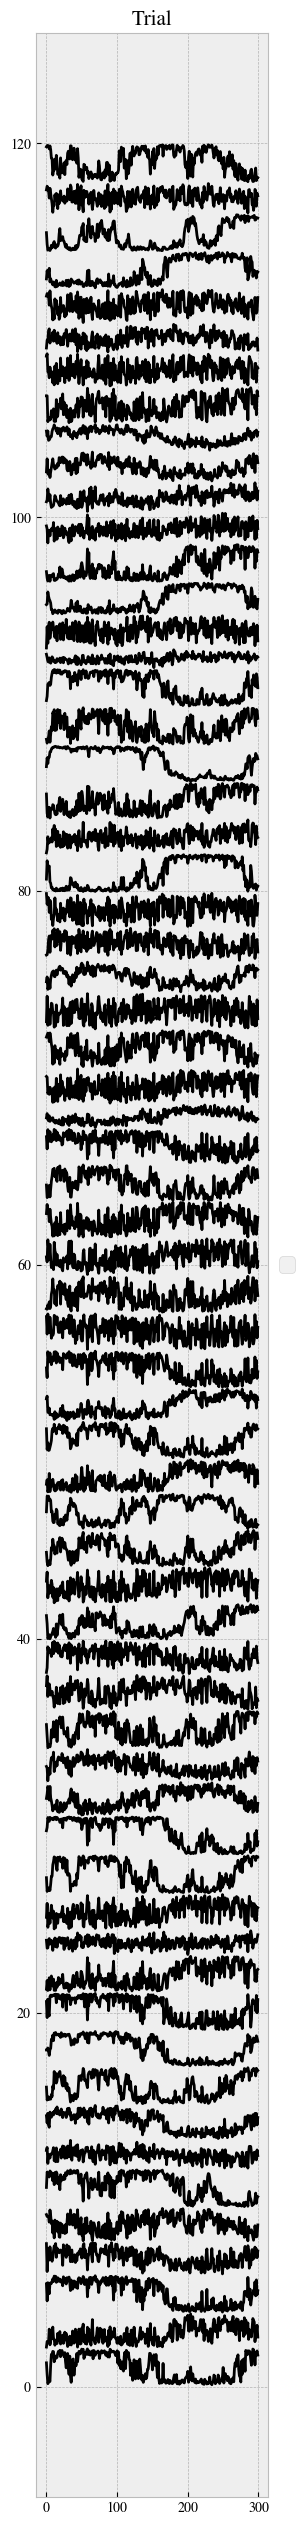

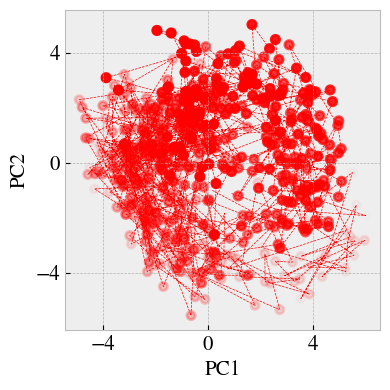

In [89]:
visualizations.plot_signals(
    [y[0]],
    titlestr='Trial'
)

visualizations.plot_states(
    [y[0],y[1]],
    ['y','y'],
    legend=False
)

In [90]:
# Define model
model_params = {
    'D': 2,
    'wgp': {
        'basis': 'T1_basis',
        'params':{
            'N': 5,
            'sigma': .5,
            'kappa': .1,
            'period': 1.,
            # 'period2': 2*jnp.pi
        }
    },
    'seed': 0
}

basis_funcs = eval('utils.'+model_params['wgp']['basis'])(**model_params['wgp']['params'])

B,T,N = y.shape

A_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=model_params['D'], D2=model_params['D'])
b_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=model_params['D'], D2=1)
C_prior = models.WeightSpaceGaussianProcess(basis_funcs, D1=N, D2=model_params['D'])

In [91]:
print(ts.shape)
print(y.shape)

(25, 299, 2)
(25, 300, 64)


jit compiling ...:   0%|          | 0/500 [00:00<?, ?it/s]

(299, 2, 2)
(299, 64)


Iter 1/500, log-prob = -774355.25, marginal log-lik = -1036098.75:   0%|          | 1/500 [00:03<26:58,  3.24s/it]

(299, 2, 2)
(299, 64)


EM stopped at iteration 86 due to decreasing marginal_log_lik:  17%|█▋        | 85/500 [00:24<01:58,  3.50it/s]   


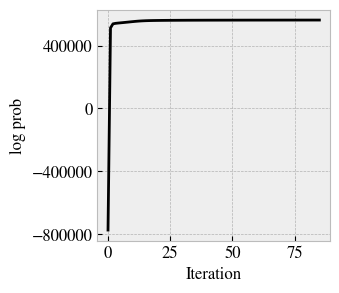

In [92]:
# Fit model
seed = model_params['seed']
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)


initial_params = models.ParamswGPLDS(
    dynamics_gp_weights = A_prior.sample_weights(A_key),
    Q = 0.05 * jnp.eye(model_params['D']),
    R = 0.05 * jnp.eye(N),
    m0 = jnp.zeros(model_params['D']),
    S0 = jnp.eye(model_params['D']),
    emissions_gp_weights = None, # C_prior.sample_weights(C_key),
    bias_gp_weights=b_prior.sample_weights(A_key),
    Cs = jnp.tile(jxr.normal(C_key, (N, 2)), (T, 1, 1)),
    bs = None, # b_prior.sample(b_key, conditions).squeeze(),
)

model = models.wGPLDS(
    params=initial_params,
    wgps={
        'A': A_prior, 
        'b': b_prior,
        'C': None,
    },
    state_dim=model_params['D'], 
    emission_dim=N,
)

log_probs = inference.fit_em(
    model, 
    emissions=y[:,1:],
    conditions=ts[:,:,1],
    num_iters=500
)

visualizations.plot_loss(log_probs,ylabel='log prob')

In [93]:
print(y.shape)
print(ts.shape)

(25, 300, 64)
(25, 299, 2)


In [94]:
params = model.params

if params.bs is None:
    params = params._replace(bs = b_prior(params.bias_gp_weights, ts[0,:,1]).squeeze())
if params.Cs is None:
    params = params._replace(Cs = C_prior(params.emissions_gp_weights, ts[0,:,1].squeeze()))
if params.Cs.ndim == 2:
    params = params._replace(Cs = jnp.tile(params.Cs[None, :, :], (T, 1, 1)))

In [98]:
# Inferred parameters 
_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    params, 
    emissions = y[0],
    inputs = ts[0,:,1],
)

reconstructed_ys = jnp.einsum('tnl,tl->tn', params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('tnl,tlk,tmk->tnm', params.Cs, smoothed_covs, params.Cs)

_As = A_prior(params.dynamics_gp_weights, ts[0,:,1])
_bs = b_prior(params.bias_gp_weights, ts[0,:,1])

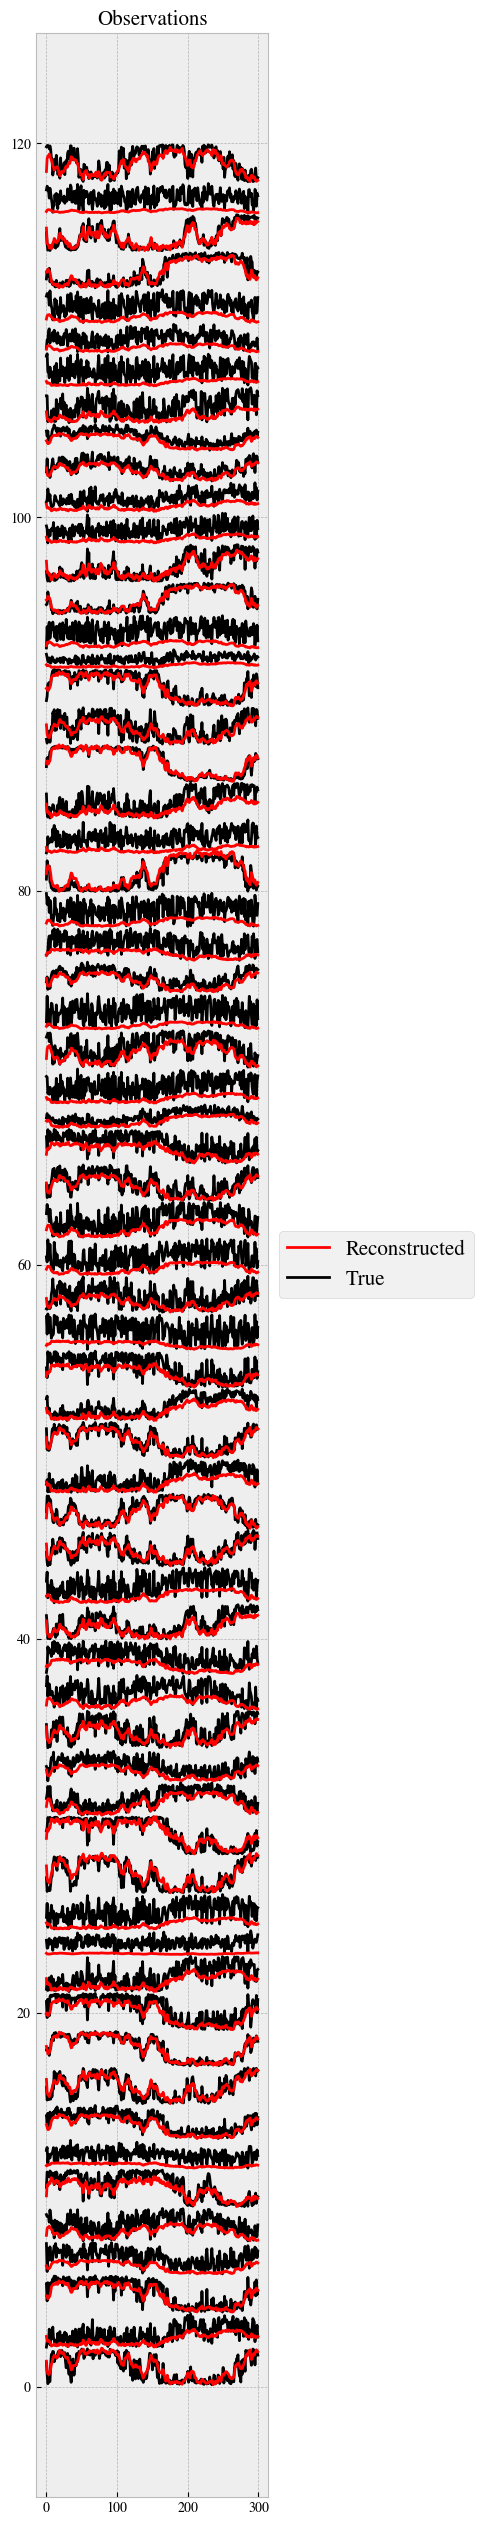

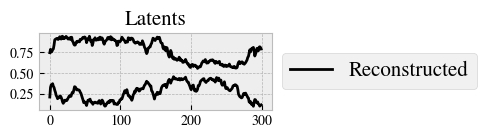

In [100]:
visualizations.plot_signals(
    [y[0],reconstructed_ys],
    titlestr='Observations',labels=['True','Reconstructed']
)

visualizations.plot_signals(
    [smoothed_means],
    titlestr='Latents',labels=['Reconstructed']
)

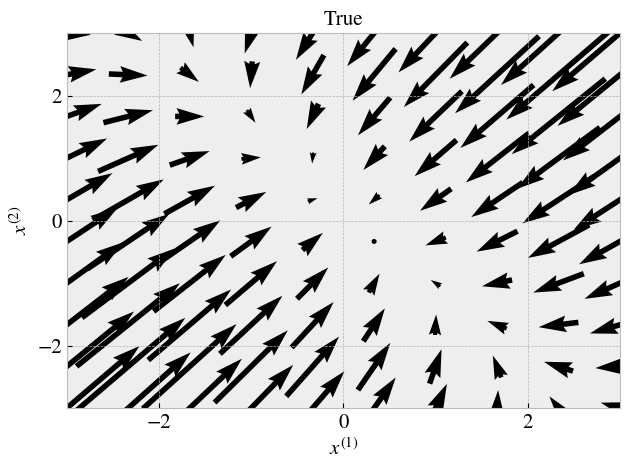

In [101]:
file = '../results/wgp_rnn/'

visualizations.time_var_dynamics(
    [_As-jnp.eye(2)[None]],
    bs=[ _bs[:,:,0]],
    titlestr='Inferred',
    save=False,
    scale=1e-1,
    xlim=[-3,3],
    ylim=[-3,3],
    file=file+'A_true'
)

/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:184: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


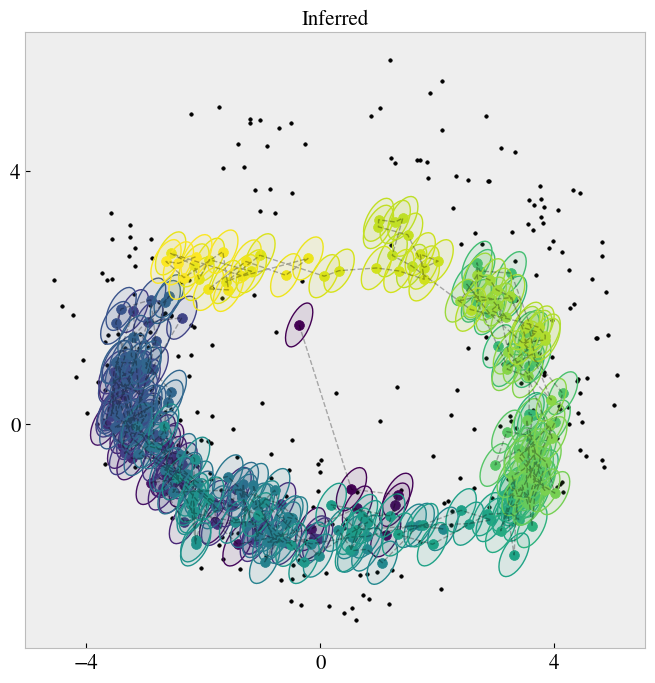

In [103]:
visualizations.visualize_pc(
    reconstructed_ys[:,None],reconstructed_ys_covs,
    pc=y[0][None],
    linewidth=1,
    titlestr='Inferred'
)

In [108]:
grid_t = jnp.linspace(-1,1,len(ts[0]))
grid_As = A_prior(params.dynamics_gp_weights, grid_t)
grid_bs = b_prior(params.bias_gp_weights, grid_t)

file = '../../results/wgp_rnn/'

visualizations.time_var_dynamics(
    [grid_As-jnp.eye(2)[None]],
    bs=[grid_bs[:,:,0]],
    titlestr='Inferred',
    save=True,
    scale=1e-1,
    xlim=[-3,3],
    ylim=[-3,3],
    file=file+'A_true'
)

MovieWriter ffmpeg unavailable; using Pillow instead.
